### Image Classification과 Object Detection, Image Segmentation의 차이

[Image Classification]

입력 이미지를 클래스나 레이블로 분류, 할당


[Object Detection]

이미지 속 여러 물체의 위치를 찾아 boxing하는 detection


[Segmentation]

-pixel-wise classification

-Sementic Segmentation과 Instance Segmentation으로 나뉨

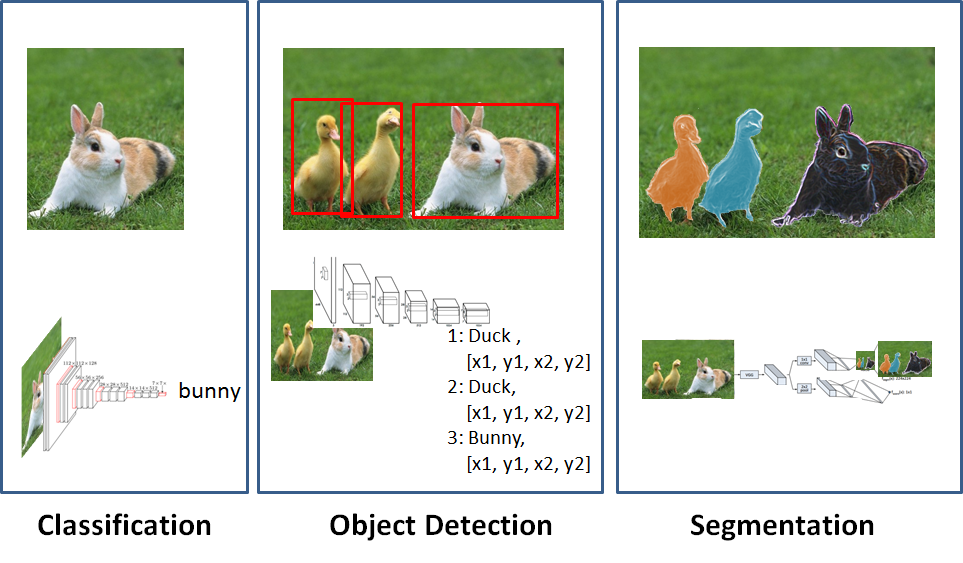
.


[Semetic Segmentation]

같은 class 물체가 있더라도, 개별 object에 대한 고려 X

[Instance Segmentation]

물체 하나 하나를 개별 object로 분류



### Semantic Segmentation 모델 구조(Encoder-Decoder)

#### 1. Contracting path (Encoder containing downsampling steps)


*   Convolutional layer, activation function, pooling layer를 가지는 일반적인 CNN의 형태

*   Layer가 깊어질수록 이미지는 downsampling되고, feature가 추출
*   height와 width는 줄어들지만 number of channels는 늘어남




#### 2. Expanding path (Decoder containing upsampling steps)


*   1단계의 반대
*   1단계에서 줄어들었던 이미지를 original size로 다시 키운다.
*   Channel 수는 줄인다.
*   Concatenate를 통해 size를 줄이면서 사라졌던 디테일을 다시 살린다.




#### 3. Final Feature Mapping Block

*   마지막 layer에서 1x1 convolution을 통해 class 수를 mapping하는데 사용된다.

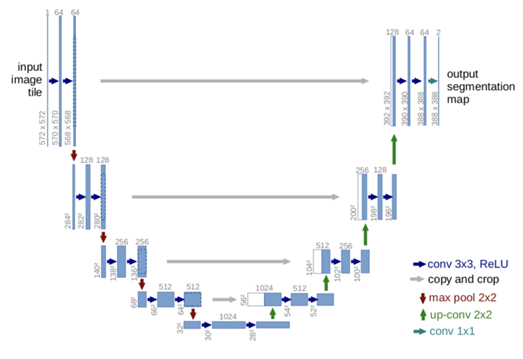

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from numpy.random import seed
seed(123)
import tensorflow  as tf
tf.random.set_seed(123)


import numpy as np 
import pandas as pd 

import imageio

import matplotlib.pyplot as plt
%matplotlib inline


import os
print(os.listdir("/content/drive/MyDrive/data/self_driving_cars_1000"))

['dataA', 'dataE', 'dataD', 'dataB', 'dataC']


In [ ]:
image_path = '/content/drive/MyDrive/data/self_driving_cars_1000/dataA/dataA/CameraRGB/'
mask_path = '/content/drive/MyDrive/data/self_driving_cars_1000/dataA/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
image_list.sort()
mask_list.sort()

Text(0.5, 1.0, 'Segmentation')

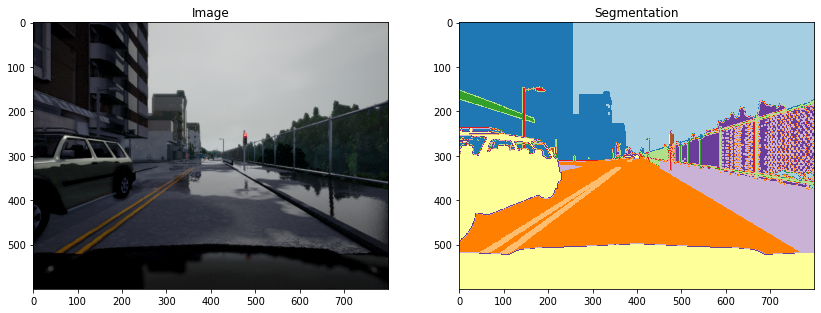

In [ ]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

#### Limited by RAM, just do road segmentation(mask == 7).

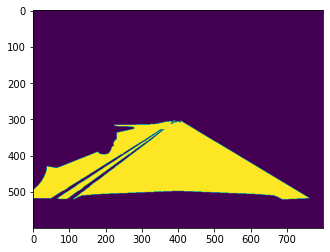

In [ ]:
road = np.zeros((600, 800))
road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
plt.imshow(road)

In [ ]:
from tqdm import tqdm

In [ ]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

100%|██████████| 1000/1000 [19:08<00:00,  1.15s/it]


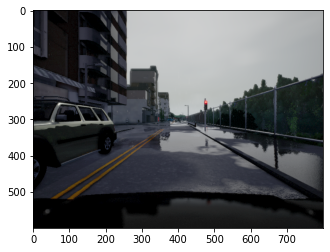

In [ ]:
plt.imshow(images[1].reshape(600, 800, 3))

In [ ]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [ ]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [ ]:
train_images.shape, val_images.shape, test_images.shape

((800, 600, 800, 3), (100, 600, 800, 3), (100, 600, 800, 3))

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [ ]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 300, 400, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', verbose=1, save_best_only=True)]

results = model.fit(train_images, train_masks, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(val_images, val_masks))

Epoch 1/100
50/50 [==============================] - 106s 1s/step - loss: 0.6687 - val_loss: 0.3795

Epoch 00001: val_loss improved from inf to 0.37952, saving model to model-sdc-seg-v2.h5
Epoch 2/100
50/50 [==============================] - 63s 1s/step - loss: 0.4001 - val_loss: 0.3468

Epoch 00002: val_loss improved from 0.37952 to 0.34679, saving model to model-sdc-seg-v2.h5
Epoch 3/100
50/50 [==============================] - 63s 1s/step - loss: 0.3820 - val_loss: 0.3331

Epoch 00003: val_loss improved from 0.34679 to 0.33310, saving model to model-sdc-seg-v2.h5
Epoch 4/100
50/50 [==============================] - 63s 1s/step - loss: 0.3725 - val_loss: 0.3084

Epoch 00004: val_loss improved from 0.33310 to 0.30843, saving model to model-sdc-seg-v2.h5
Epoch 5/100
50/50 [==============================] - 63s 1s/step - loss: 0.3566 - val_loss: 0.3266

Epoch 00005: val_loss did not improve from 0.30843
Epoch 6/100
50/50 [==============================] - 63s 1s/step - loss: 0.3150 - va

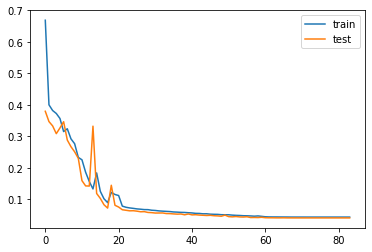

In [ ]:
from matplotlib import pyplot 
pyplot.plot(results.history['loss'], label='train') 
pyplot.plot(results.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
model.save('final-road-seg-model-v2.h5')

Text(0.5, 1.0, 'Ground truth')

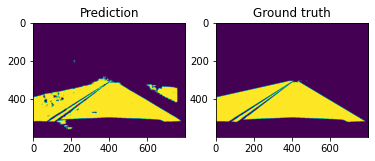

In [ ]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')

Text(0.5, 1.0, 'Ground truth')

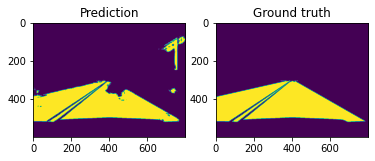

In [ ]:
NUMBER += 1
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')